In [1]:
# Pull data command:
# python download_data.py --project=discrete-mbrl-soft-vqvae-best --history_vars n_step goal_state_distrib_kl_div goal_delayed_state_distrib_kl_div goal_uniform_distrib_kl_div explore_right_state_distrib_kl_div explore_right_delayed_state_distrib_kl_div explore_right_uniform_distrib_kl_div --params codebook_size filter_size eval_policy env_name ae_model_type latent_dim final_latent_dim e2e_loss

In [ ]:
from collections import Counter
import os
import sys
sys.path.append(os.path.abspath('../../..'))
from plotting_utils import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns

%matplotlib inline
set_matplotlib_style()

In [3]:
data_path = 'data/discrete-mbrl-soft-vqvae-best_data.csv'
df = pd.read_csv(data_path, index_col=0)
df['Model Type'] = df['ae_model_type']

model_type_map = {
  'soft_vqvae': 'Quantized',
  'vqvae': 'One-Hot',
}
df['Model Type'] = df['Model Type'].apply(lambda x: model_type_map[x])

df.head()

,step,n_step,explore_right_state_distrib_kl_div,explore_right_delayed_state_distrib_kl_div,explore_right_uniform_distrib_kl_div,ae_model_type,codebook_size,env_name,filter_size,final_latent_dim,latent_dim,experiment_key,goal_state_distrib_kl_div,goal_delayed_state_distrib_kl_div,goal_uniform_distrib_kl_div,Model Type
0,1,1,1.437187,-1.257582e-08,4.125888,vqvae,64,minigrid-crossing-stochastic,6,2304,None,bcac7b257c464f9abf6a456a98374cb9,NaN,NaN,NaN,One-Hot
1,2,2,1.092798,1.487571e+01,3.252357,vqvae,64,minigrid-crossing-stochastic,6,2304,None,bcac7b257c464f9abf6a456a98374cb9,NaN,NaN,NaN,One-Hot
2,3,3,1.362391,1.245456e+01,2.838870,vqvae,64,minigrid-crossing-stochastic,6,2304,None,bcac7b257c464f9abf6a456a98374cb9,NaN,NaN,NaN,One-Hot
3,4,4,1.419378,8.472774e+00,2.556366,vqvae,64,minigrid-crossing-stochastic,6,2304,None,bcac7b257c464f9abf6a456a98374cb9,NaN,NaN,NaN,One-Hot
4,5,5,2.850567,7.351248e+00,2.272615,vqvae,64,minigrid-crossing-stochastic,6,2304,None,bcac7b257c464f9abf6a456a98374cb9,NaN,NaN,NaN,One-Hot


In [4]:
kl_div_columns = [col for col in df.columns if 'kl_div' in col]
# Drop the rows where all of the columns are NaN
df = df.dropna(subset=kl_div_columns, how='all')

In [5]:
# Work out the policy types and simplify the KL divergence columns

def infer_policy_type(row):
  for key, val in row.items():
    if 'kl_div' in key and val is not None and not np.isnan(val):
      return key[:key.find('state')-1]
    

df['policy_type'] = df.apply(infer_policy_type, axis=1)
df['state_distrib_kl_div'] = df.apply(
  lambda row: row[row['policy_type'] + '_state_distrib_kl_div'],
  axis=1)
df['uniform_distrib_kl_div'] = df.apply(
  lambda row: row[row['policy_type'] + '_uniform_distrib_kl_div'],
  axis=1)
# df['delayed_state_distrib_kl_div'] = df.apply(
#   lambda row: row[row['policy_type'] + '_delayed_state_distrib_kl_div'],
#   axis=1)

df.drop(columns=kl_div_columns, inplace=True)

64


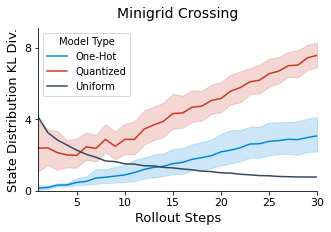

60


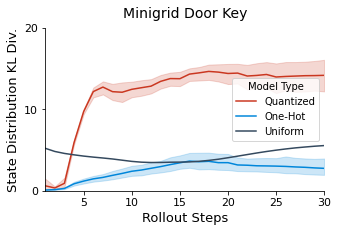

In [8]:
min_runs = 30
for keys, group in df.groupby(['env_name', 'policy_type']):
    n_runs = len(group['experiment_key'].unique())
    min_runs = min(min_runs, n_runs)

for keys, group in df.groupby(['env_name', 'policy_type']):
    # Count the number of runs (number of times n_step == 30) for each ae_model_type
    print(len(group['experiment_key'].unique()))

    baseline_row_sets = []
    for baseline_type in ['uniform']:
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            if keys[1] == 'random' and baseline_type == 'delayed_state':
                continue
            baseline_rows = group[group['ae_model_type'] == 'vqvae']
            baseline_rows['state_distrib_kl_div'] = baseline_rows[f'{baseline_type}_distrib_kl_div']
            baseline_title = baseline_type.replace('_', ' ').title()
            baseline_rows['Model Type'] = f'{baseline_title}'
            baseline_rows['experiment_key'] = baseline_rows['experiment_key'] \
                + f'_{baseline_type}_baseline'
            baseline_rows = baseline_rows[
                baseline_rows['experiment_key'] == baseline_rows['experiment_key'].iloc[0]
            ]
            if baseline_type == 'delayed_state':
                # Drop n_step = 1
                baseline_rows = baseline_rows.drop(
                    baseline_rows[baseline_rows['n_step'] == 1].index)
            baseline_row_sets.append(baseline_rows)

    max_base_y = np.percentile(group['state_distrib_kl_div'], 93)

    for baseline_rows in baseline_row_sets:
        group = pd.concat([group, baseline_rows])

    # Reindex group
    group = group.reset_index(drop=True)

    # Set up the figure and axis
    fig, ax = plt.subplots()

    # Create a list of unique Model Types
    model_types = group['Model Type'].unique()
    color_palette = get_color_palette(group['Model Type'].unique())
    
    sns.lineplot(
        data=group, x='n_step', y='state_distrib_kl_div', hue='Model Type',
        palette=color_palette, errorbar='ci', estimator=np.mean)

    plt.title(f'{standardize_env_name(keys[0])}')
    set_fig_labels('Rollout Steps', 'State Distribution KL Div.')

    plt.xlim(1, 30)
    plt.ylim(0, 1.1 * max_base_y)

    yticks = plt.gca().get_yticks()
    plt.gca().set_yticks(yticks[::2])

    save_fig_versions(f'{standardize_env_name(keys[0])}_quantized')
    plt.show()
